In [1]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Dropout, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [2]:
# Audio files and CSV file containing metadata
file_path = './audio'
urbansound8k = pd.read_csv('./metadata/UrbanSound8K.csv')
file_viz = glob.glob('./audio/fold1/*')

In [3]:
#pd.set_option('display.max_rows', None)
urbansound8k.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [4]:
#Change dataset to get interest classes to classify
urbansound8k = urbansound8k.loc[((urbansound8k["class"]=="gun_shot") | (urbansound8k["class"]=="siren"))]
urbansound8k.head()

slice_file_name    fsID  start      end  salience  fold  classID  \
106  102305-6-0-0.wav  102305    0.0  2.61161         1     1        6   
114  102853-8-0-0.wav  102853    0.0  4.00000         2     7        8   
115  102853-8-0-1.wav  102853    0.5  4.50000         2     7        8   
116  102853-8-0-2.wav  102853    1.0  5.00000         2     7        8   
117  102853-8-0-3.wav  102853    1.5  5.50000         2     7        8   

        class  
106  gun_shot  
114     siren  
115     siren  
116     siren  
117     siren

In [5]:
class_map = {'0' : 'air_conditioner', '1' : 'car_horn', '2' : 'children_playing', '3' : 'dog_bark', '4' : 'drilling',
                 '5' : 'engine_idling', '6' : 'gun_shot', '7' : 'jackhammer', '8' : 'siren', '9' : 'street_music'}
#Mapping classes to use
pd.DataFrame(sorted(list(class_map.items())))

0                 1
0  0   air_conditioner
1  1          car_horn
2  2  children_playing
3  3          dog_bark
4  4          drilling
5  5     engine_idling
6  6          gun_shot
7  7        jackhammer
8  8             siren
9  9      street_music

In [6]:
#Take samples of dataset to preview
samples = [(class_map[label], [f for f in file_viz if f.split('-')[1] == label][0]) for label in class_map.keys()]

In [7]:
import librosa
import soundfile as sf
import numpy as np

def get_sound_data(path, sr=22050):
    # Read the audio file
    data, fsr = sf.read(path)

    # If the audio is stereo, make sure to average the channels to mono
    if len(data.shape) > 1:
        data = np.mean(data, axis=1)

    # Resample the data to the desired sample rate (using librosa's resample function)
    data_22k = librosa.resample(data, orig_sr=fsr, target_sr=sr)

    return data_22k, sr

# Take samples from the dataset to preview
sample_data = [(sample[0], get_sound_data(sample[1])) for sample in samples]

# Check the shape of the data
sample_shapes = [(sample[0], sample[1][0].shape) for sample in sample_data]
print(sample_shapes)


[('air_conditioner', (44982,)), ('car_horn', (5513,)), ('children_playing', (88200,)), ('dog_bark', (88200,)), ('drilling', (88200,)), ('engine_idling', (88200,)), ('gun_shot', (57551,)), ('jackhammer', (88200,)), ('siren', (88200,)), ('street_music', (88200,))]


In [8]:
#Show samples of data to be played.
for data in sample_data:
    print(data[0], ':')
    IPython.display.display(IPython.display.Audio(data=data[1][0], rate=data[1][1]))

air_conditioner :


car_horn :


children_playing :


dog_bark :


drilling :


engine_idling :


gun_shot :


jackhammer :


siren :


street_music :


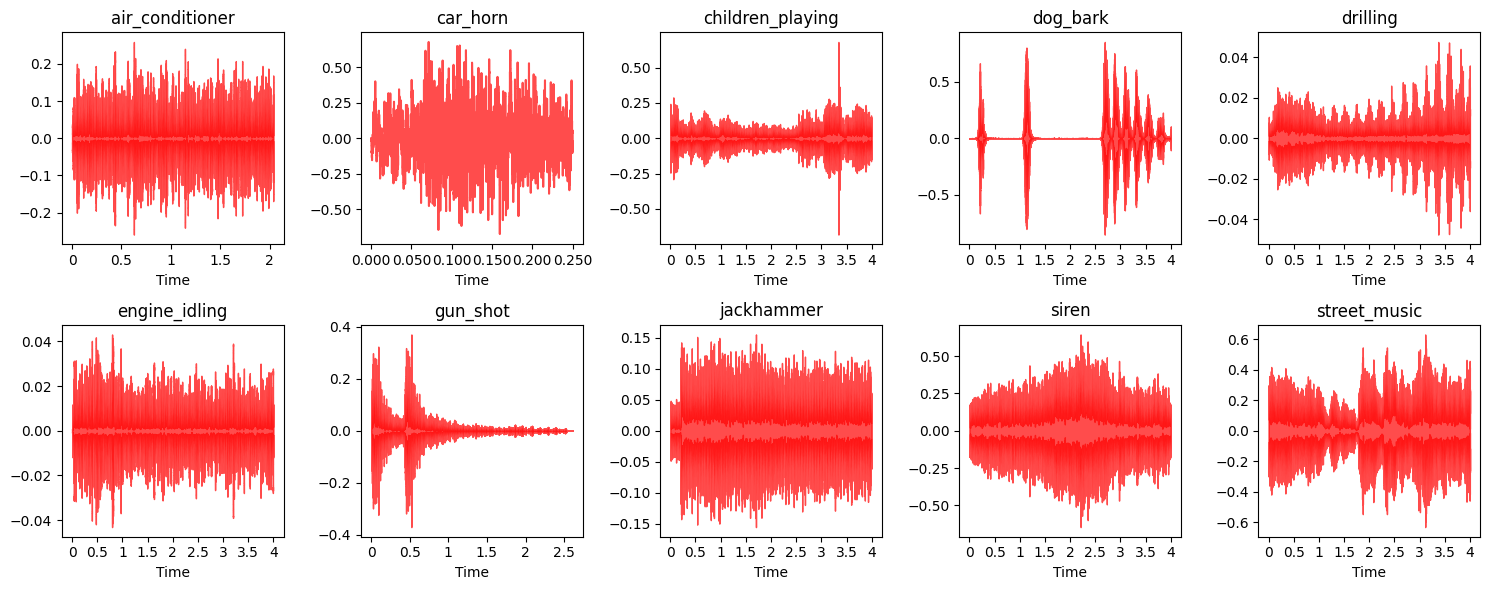

In [9]:
#Showing waveforms of taked samples
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    librosa.display.waveshow(item[1][0], sr=item[1][1], color='r', alpha=0.7)
    plt.title(item[0])
    i += 1
plt.tight_layout()

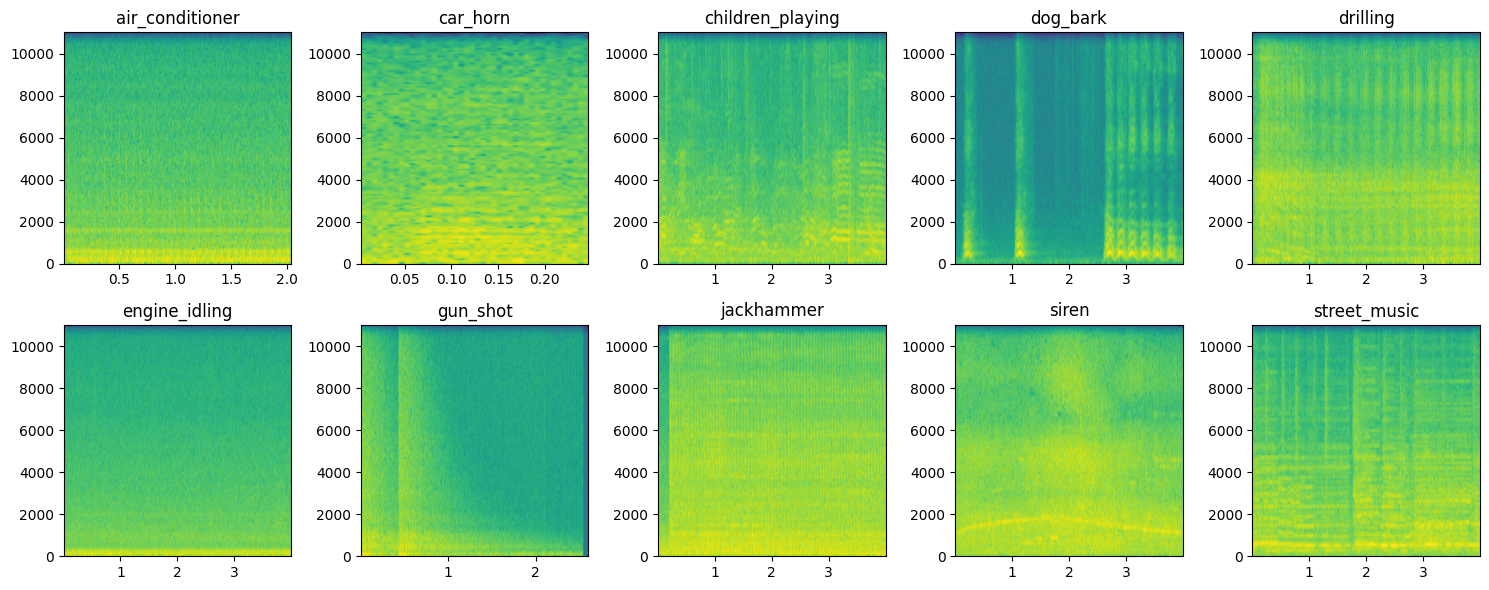

In [10]:
#Showing spectograms of taked samples
i = 1
fig = plt.figure(figsize=(15, 6))
for item in sample_data:
    plt.subplot(2, 5, i)
    specgram(item[1][0], Fs=item[1][1])
    plt.title(item[0])
    i += 1
plt.tight_layout()

### Extracting features using Librosa

In [11]:
#Function to extract features with librosa, getting mel frequency cepstrals coeficient
#Add pading to have same size of coeficients as input to model
max_pad_len = 174
def extract_features(file_name):
    try:
        audio, sample_rate = librosa.load(file_name)

        # Check if audio length is greater than 0
        if len(audio) == 0:
            print(f"Empty audio file: {file_name}")
            return None

        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        print(f"Error: {e}")
        return None

    return mfccs


In [12]:
features = []

# Iterate through each sound file and extract the features
for index, row in tqdm(urbansound8k.iterrows(), total=urbansound8k.shape[0], desc="Processing files"):
    file_name = os.path.join(os.path.abspath(file_path), 'fold' + str(row["fold"]) + '/', str(row["slice_file_name"]))
    class_label = row["classID"]
    fold = row["fold"]

    try:
        data = extract_features(file_name)
        if data is not None:
            # print(f"Extracted features from {file_name}")
            features.append([data, class_label, fold])
    except Exception as e:
        print(f"Error encountered while parsing file: {file_name}")
        print(f"Error: {e}")

# Convert into a Panda dataframe
featuresdf = pd.DataFrame(features, columns=['feature', 'class_label', 'fold'])


Processing files: 100%|██████████| 1303/1303 [01:20<00:00, 16.13it/s]


In [13]:
featuresdf.head()

feature  class_label  fold
0  [[-145.07484, -90.33111, -93.73102, -105.46187...            6     1
1  [[-232.90999, -202.5418, -193.06873, -201.0949...            8     7
2  [[-227.12007, -199.35532, -204.4722, -206.6335...            8     7
3  [[-203.43169, -198.27023, -210.83688, -214.792...            8     7
4  [[-251.53769, -223.92719, -227.20724, -230.046...            8     7

In [14]:
featuresdf2 = pd.DataFrame(features, columns=['feature','class_label', 'fold'])
featuresdf2.groupby(["fold"]).count()

feature  class_label
fold                      
1         121          121
2         126          126
3         155          155
4         204          204
5         111          111
6         120          120
7         128          128
8         110          110
9         113          113
10        115          115

In [18]:
# === Fixed label encoding and fold split ===

num_rows = 40
num_columns = 174
num_channels = 1

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Initialize arrays
X_cv = np.empty(10, dtype=object)
y_cv = np.empty(10, dtype=object)

# Fit LabelEncoder ONCE globally
le = LabelEncoder()
le.fit(featuresdf2['class_label'])

# Extract data fold-wise with consistent encoding
for index in range(1, 11):
    fold_data = featuresdf2[featuresdf2['fold'] == index]
    features = np.array(fold_data['feature'].tolist())
    labels = le.transform(fold_data['class_label'])

    # Reshape features
    features = features.reshape(features.shape[0], num_rows, num_columns, num_channels)

    # One-hot encode labels with 10 classes
    onehot_labels = to_categorical(labels, num_classes=10)

    X_cv[index - 1] = features
    y_cv[index - 1] = onehot_labels


In [19]:
#Some validations values
print(len(X_cv))
print(len(y_cv))
print(type(X_cv[0]))
print(y_cv[0].shape)
print(y_cv[0][1].shape)
num_labels = y_cv[0].shape[1]
print(num_labels)

10
10
<class 'numpy.ndarray'>
(121, 10)
(10,)
10


# Creating the Model

In [20]:
# Constructing model with RELu and SoftMax activation functions:
def getModel():
    model = Sequential()
    model.add(Conv2D(filters=16, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=32, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))
    model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [21]:
def run_fold(fold):
    print(f"Running fold {fold}...")

    if fold == 0:
        # Use random 80-20 split for fold 0
        combined_X = np.concatenate(X_cv, axis=0)
        combined_y = np.concatenate(y_cv, axis=0)
        from sklearn.model_selection import train_test_split
        X_train, X_val, y_train, y_val = train_test_split(
            combined_X, combined_y,
            test_size=0.2, random_state=42,
            stratify=np.argmax(combined_y, axis=1)
        )
    else:
        # Use k-fold split for other folds
        X_train = np.concatenate([X_cv[i] for i in range(len(X_cv)) if i != fold - 1])
        y_train = np.concatenate([y_cv[i] for i in range(len(y_cv)) if i != fold - 1])
        X_val = X_cv[fold - 1]
        y_val = y_cv[fold - 1]

    # Create and compile model
    model = getModel()
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

    # Define model checkpoint
    checkpoint = ModelCheckpoint(f'saved_models/best_model_fold_{fold}.keras',
                                 monitor='val_loss',
                                 save_best_only=True,
                                 mode='min')

    # Train the model
    start = datetime.now()
    history = model.fit(
        X_train, y_train,
        batch_size=256,
        epochs=40,
        validation_data=(X_val, y_val),
        callbacks=[checkpoint],
        verbose=1
    )
    duration = datetime.now() - start
    print(f"Training completed in time for fold {fold}: {duration}")

    # Evaluate on validation set
    scores = model.evaluate(X_val, y_val, verbose=0)
    val_acc = scores[1] * 100
    val_loss = scores[0]
    print(f"Score for fold {fold}:")
    print(f" - Final Validation Accuracy: {val_acc:.2f}%")
    print(f" - Final Validation Loss: {val_loss:.4f}")

    # Print training history summary
    print(f" - Final Training Accuracy: {history.history['accuracy'][-1]*100:.2f}%")
    print(f" - Final Training Loss: {history.history['loss'][-1]:.4f}")
    print(f" - Best Validation Accuracy: {max(history.history['val_accuracy'])*100:.2f}%")
    print(f" - Lowest Validation Loss: {min(history.history['val_loss']):.4f}")

    return model, history

In [22]:
model0, history0 = run_fold(0)

Running fold 0...


C:\Users\TB Pal\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.3960 - loss: 8.6557 - val_accuracy: 0.7126 - val_loss: 2.7390
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.7139 - loss: 3.3842 - val_accuracy: 0.7126 - val_loss: 1.1225
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.7544 - loss: 0.9288 - val_accuracy: 0.8966 - val_loss: 0.3730
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - accuracy: 0.7193 - loss: 1.0550 - val_accuracy: 0.7701 - val_loss: 0.5136
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 262ms/step - accuracy: 0.8048 - loss: 0.5013 - val_accuracy: 0.7931 - val_loss: 0.4683
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - accuracy: 0.8514 - loss: 0.3494 - val_accuracy: 0.8851 - val_loss: 0.2681
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 265ms/step - accuracy: 0.8886 - loss: 0.3443 - val_accuracy: 0.9272 - val_loss: 0.2375
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.9023 - loss: 0.3005 - val_accuracy: 0.8659 - val_loss: 0.2

In [23]:
model1, history1 = run_fold(1)

Running fold 1...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.6654 - loss: 1.9503 - val_accuracy: 0.8264 - val_loss: 0.4793
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7541 - loss: 0.9976 - val_accuracy: 0.9256 - val_loss: 0.1227
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8431 - loss: 0.5653 - val_accuracy: 0.9339 - val_loss: 0.1408
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8844 - loss: 0.3276 - val_accuracy: 0.9835 - val_loss: 0.0537
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 162ms/step - accuracy: 0.9125 - loss: 0.2257 - val_accuracy: 0.9752 - val_loss: 0.0784
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 195ms/step - accuracy: 0.9206 - loss: 0.2130 - val_accuracy: 1.0000 - val_loss: 0.0348
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.9554 - loss: 0.1408 - val_accuracy: 1.0000 - val_loss: 0.0294
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 206ms/step - accuracy: 0.9635 - loss: 0.1031 - val_accuracy: 1.0000 - 

In [24]:
model2, history2 = run_fold(2)

Running fold 2...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - accuracy: 0.3041 - loss: 12.2173 - val_accuracy: 0.7222 - val_loss: 1.4215
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7081 - loss: 2.7567 - val_accuracy: 0.7222 - val_loss: 0.9459
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7162 - loss: 1.5850 - val_accuracy: 0.8016 - val_loss: 0.5524
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7484 - loss: 0.6431 - val_accuracy: 0.9603 - val_loss: 0.2853
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8372 - loss: 0.3287 - val_accuracy: 0.9206 - val_loss: 0.2429
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - accuracy: 0.7758 - loss: 0.4980 - val_accuracy: 0.9921 - val_loss: 0.1695
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8880 - loss: 0.2306 - val_accuracy: 0.9841 - val_loss: 0.1772
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.9239 - loss: 0.2139 - val_accuracy: 1.0000 - va

In [25]:
model3, history3 = run_fold(3)

Running fold 3...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 4s/step - accuracy: 0.3895 - loss: 7.5403 - val_accuracy: 0.8710 - val_loss: 0.2455
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 207ms/step - accuracy: 0.7475 - loss: 0.9334 - val_accuracy: 0.8194 - val_loss: 0.2963
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.8131 - loss: 0.6136 - val_accuracy: 0.9484 - val_loss: 0.1215
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step - accuracy: 0.8625 - loss: 0.3659 - val_accuracy: 0.9097 - val_loss: 0.1722
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 221ms/step - accuracy: 0.9012 - loss: 0.3615 - val_accuracy: 0.9806 - val_loss: 0.0709
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step - accuracy: 0.9145 - loss: 0.3113 - val_accuracy: 0.9355 - val_loss: 0.1655
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 274ms/step - accuracy: 0.9086 - loss: 0.3117 - val_accuracy: 0.9806 - val_loss: 0.0637
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 236ms/step - accuracy: 0.9427 - loss: 0.1510 - val_accuracy: 0.

In [26]:
model4, history4 = run_fold(4)

Running fold 4...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 2s/step - accuracy: 0.5285 - loss: 8.2884 - val_accuracy: 0.8137 - val_loss: 1.9393
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7023 - loss: 5.9349 - val_accuracy: 0.8627 - val_loss: 0.4896
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.7616 - loss: 1.3191 - val_accuracy: 0.8676 - val_loss: 0.2338
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 197ms/step - accuracy: 0.8209 - loss: 0.5957 - val_accuracy: 0.8578 - val_loss: 0.4682
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.7673 - loss: 1.1427 - val_accuracy: 0.8480 - val_loss: 0.2958
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step - accuracy: 0.8713 - loss: 0.3986 - val_accuracy: 0.9559 - val_loss: 0.1479
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - accuracy: 0.8902 - loss: 0.3701 - val_accuracy: 0.9069 - val_loss: 0.1826
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - accuracy: 0.9259 - loss: 0.1961 - val_accuracy: 0.8873 - 

In [27]:
model5, history5 = run_fold(5)

Running fold 5...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - accuracy: 0.4323 - loss: 3.2639 - val_accuracy: 0.8559 - val_loss: 0.4638
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7494 - loss: 0.6000 - val_accuracy: 0.7748 - val_loss: 0.3952
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8502 - loss: 0.3307 - val_accuracy: 0.8468 - val_loss: 0.2795
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.8793 - loss: 0.2577 - val_accuracy: 0.8468 - val_loss: 0.2745
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9246 - loss: 0.1904 - val_accuracy: 0.9369 - val_loss: 0.1953
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9228 - loss: 0.2161 - val_accuracy: 0.9009 - val_loss: 0.1945
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.9291 - loss: 0.1517 - val_accuracy: 0.9730 - val_loss: 0.1482
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step - accuracy: 0.9569 - loss: 0.1272 - val_accuracy: 0.9730 - val_los

In [28]:
model6, history6 = run_fold(6)

Running fold 6...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 6s/step - accuracy: 0.3939 - loss: 12.5412 - val_accuracy: 0.6167 - val_loss: 0.8740
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 217ms/step - accuracy: 0.6733 - loss: 1.8605 - val_accuracy: 0.6167 - val_loss: 0.5906
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 175ms/step - accuracy: 0.7548 - loss: 1.3194 - val_accuracy: 0.6250 - val_loss: 0.6203
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 254ms/step - accuracy: 0.8029 - loss: 0.8780 - val_accuracy: 0.9917 - val_loss: 0.2709
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - accuracy: 0.8298 - loss: 0.7132 - val_accuracy: 0.7000 - val_loss: 0.4005
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 228ms/step - accuracy: 0.8307 - loss: 0.5407 - val_accuracy: 0.8833 - val_loss: 0.3067
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step - accuracy: 0.9016 - loss: 0.3008 - val_accuracy: 0.9333 - val_loss: 0.2490
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.9105 - loss: 0.2804 - val_accuracy: 0

In [29]:
model7, history7 = run_fold(7)

Running fold 7...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 4s/step - accuracy: 0.4978 - loss: 3.9885 - val_accuracy: 0.7812 - val_loss: 0.4306
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.7168 - loss: 1.0415 - val_accuracy: 0.6328 - val_loss: 1.0553
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 177ms/step - accuracy: 0.7938 - loss: 0.8302 - val_accuracy: 0.7734 - val_loss: 0.4306
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.8461 - loss: 0.4599 - val_accuracy: 0.7109 - val_loss: 0.6728
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - accuracy: 0.8845 - loss: 0.3400 - val_accuracy: 0.8828 - val_loss: 0.2661
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.9047 - loss: 0.3087 - val_accuracy: 0.7734 - val_loss: 0.3678
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.9423 - loss: 0.1789 - val_accuracy: 0.9609 - val_loss: 0.1466
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.9480 - loss: 0.1732 - val_accuracy: 0.96

In [30]:
model8, history8 = run_fold(8)

Running fold 8...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 26s 6s/step - accuracy: 0.2843 - loss: 9.6125 - val_accuracy: 0.7273 - val_loss: 1.0245
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.7205 - loss: 1.9326 - val_accuracy: 0.6727 - val_loss: 0.5060
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.6872 - loss: 1.2383 - val_accuracy: 0.8364 - val_loss: 0.4043
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7584 - loss: 0.8839 - val_accuracy: 0.9364 - val_loss: 0.1771
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8911 - loss: 0.3157 - val_accuracy: 0.9909 - val_loss: 0.1390
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 178ms/step - accuracy: 0.8997 - loss: 0.3251 - val_accuracy: 0.9364 - val_loss: 0.1726
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.8908 - loss: 0.2736 - val_accuracy: 0.9727 - val_loss: 0.1276
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.9341 - loss: 0.1805 - val_accuracy: 0.9909 - val_l

In [31]:
model9, history9 = run_fold(9)

Running fold 9...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - accuracy: 0.2736 - loss: 8.6919 - val_accuracy: 0.7257 - val_loss: 2.2668
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 5s/step - accuracy: 0.7189 - loss: 2.7254 - val_accuracy: 0.7257 - val_loss: 1.1437
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 916ms/step - accuracy: 0.7407 - loss: 0.9791 - val_accuracy: 0.7965 - val_loss: 0.4835
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 184ms/step - accuracy: 0.6899 - loss: 0.9053 - val_accuracy: 0.7257 - val_loss: 0.5658
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 174ms/step - accuracy: 0.7763 - loss: 0.5344 - val_accuracy: 0.7257 - val_loss: 0.5036
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 22s 6s/step - accuracy: 0.8474 - loss: 0.3443 - val_accuracy: 0.9115 - val_loss: 0.2204
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.8844 - loss: 0.3251 - val_accuracy: 0.8407 - val_loss: 0.2580
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.9167 - loss: 0.2054 - val_accuracy: 0.8230

In [32]:
model10, history10 = run_fold(10)

Running fold 10...
Epoch 1/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step - accuracy: 0.2625 - loss: 22.5216 - val_accuracy: 0.7217 - val_loss: 3.5433
Epoch 2/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7056 - loss: 2.9012 - val_accuracy: 0.7304 - val_loss: 0.6779
Epoch 3/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/step - accuracy: 0.7087 - loss: 1.3220 - val_accuracy: 0.7217 - val_loss: 1.7212
Epoch 4/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7531 - loss: 1.3581 - val_accuracy: 0.7739 - val_loss: 0.3866
Epoch 5/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 182ms/step - accuracy: 0.7528 - loss: 0.9871 - val_accuracy: 0.7217 - val_loss: 1.1376
Epoch 6/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.8036 - loss: 0.7328 - val_accuracy: 0.7391 - val_loss: 0.6080
Epoch 7/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 179ms/step - accuracy: 0.8283 - loss: 0.5198 - val_accuracy: 0.7304 - val_loss: 0.6887
Epoch 8/40
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - accuracy: 0.8671 - loss: 0.4465 - val_accuracy: 0.73

# Evaluation Metrics

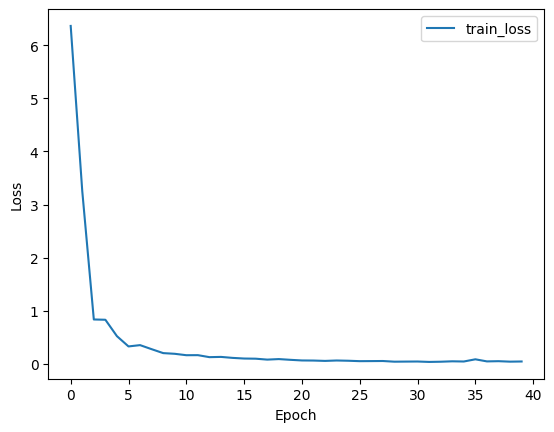

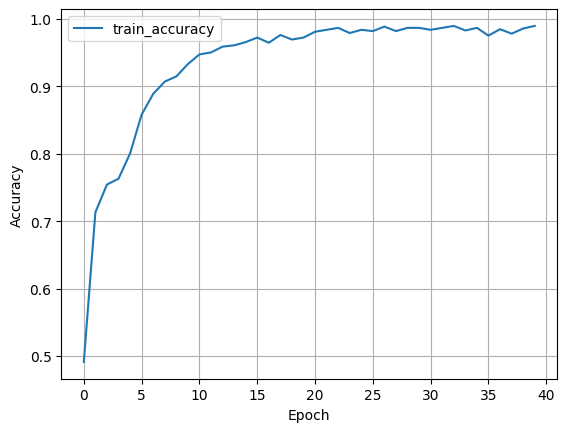

In [33]:
# Plotting Loss of Model

metrics = history0.history
plt.plot(history0.epoch, metrics['loss'])
plt.legend(['train_loss', 'test_loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plotting Accuracy of Model

plt.plot(history0.history['accuracy'], label='train_accuracy')
#plt.plot(history0.history['val_accuracy'], label='test_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Reload a fresh Keras model from the saved model

In [34]:
import IPython.display
import librosa
import librosa.display
import pandas as pd
import os
import struct
import glob
import soundfile as sf
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.callbacks import ModelCheckpoint
from datetime import datetime
from sklearn import metrics
import librosa as lb
import IPython.display as ipd
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

# Predict Function with audio path as input

In [35]:
import numpy as np
import IPython.display as ipd
from tensorflow.keras.models import load_model

def predict(path, model_or_path):
    num_rows = 40
    num_columns = 174
    num_channels = 1

    # If model is a string path, load it
    if isinstance(model_or_path, str):
        model = load_model(model_or_path)
    else:
        model = model_or_path

    # Extract features
    audio = extract_features(path)
    if audio is None:
        print("Failed to extract features.")
        return None

    audioP = audio.reshape(1, num_rows, num_columns, num_channels)

    # Predict
    probOut = model.predict(audioP)[0]

    print("Class Probabilities:")
    for i, prob in enumerate(probOut):
        class_name = class_map.get(str(i), f"Unknown ({i})")
        print(f"Class {i} ({class_name}): Probability {prob:.4f}")

    indexMax = np.argmax(probOut)
    maxProb = probOut[indexMax]
    classP = class_map[str(indexMax)]

    print(f'\nClass predicted: {classP} with probability {maxProb:.4f}\n')
    return ipd.Audio(path)


In [36]:
from tensorflow.keras.models import load_model
import numpy as np
import IPython.display as ipd
import os

def predict_combined(audio_path, model_dir="D:/UrbanSound8K/saved_models/", folds=10):
    num_rows = 40
    num_columns = 174
    num_channels = 1

    # Extract MFCC features
    audio = extract_features(audio_path)
    if audio is None:
        print("Feature extraction failed.")
        return None

    audio_input = audio.reshape(1, num_rows, num_columns, num_channels)

    total_prob = np.zeros(10)  # Expected number of classes
    valid_models = 0

    for fold in range(1, folds + 1):
        model_path = os.path.join(model_dir, f"best_model_fold_{fold}.keras")
        if not os.path.exists(model_path):
            print(f"Model for fold {fold} not found: {model_path}")
            continue

        model = load_model(model_path)
        prob = model.predict(audio_input)[0]

        if prob.shape[0] != 10:
            print(f"Skipping fold {fold}: Expected 10 classes but got {prob.shape[0]}")
            continue

        total_prob += prob
        valid_models += 1

    if valid_models == 0:
        print("No valid models were found for prediction.")
        return None

    avg_prob = total_prob / valid_models

    print("\nAveraged Class Probabilities:")
    for i, prob in enumerate(avg_prob):
        class_name = class_map.get(str(i), f"Class {i}")
        print(f"{class_name} (Class {i}): {prob:.4f}")

    indexMax = np.argmax(avg_prob)
    maxProb = avg_prob[indexMax]
    classP = class_map[str(indexMax)]

    print(f"\Final Predicted Class: {classP} with confidence {maxProb:.4f}\n")
    return ipd.Audio(audio_path)

<>:53: SyntaxWarning: invalid escape sequence '\F'
<>:53: SyntaxWarning: invalid escape sequence '\F'
C:\Users\TB Pal\AppData\Local\Temp\ipykernel_85544\2483512995.py:53: SyntaxWarning: invalid escape sequence '\F'
  print(f"\Final Predicted Class: {classP} with confidence {maxProb:.4f}\n")


In [38]:
predict_combined('D:/UrbanSound8K/EvaluationAudio/drilling_1.wav')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step

Averaged Class Probabilities:
air_conditioner (Class 0): 0.0496
car_horn (Class 1): 0.9497
children_playing (Class 2): 0.0001
dog_bark (Class 3): 0.0001
drilling (Class 4): 0.0001
engine_idling (Class 5): 0.0001
gun_shot (Class 6): 0.0000
jackhammer (Class 7): 0.0001
siren (Class 8): 0.0001
street_music (Class 9): 0.0000
\Final Predicted Class: car_horn with confidence 0.9497



In [ ]:
predict('D:/UrbanSound8K/EvaluationAudio/dog_bark_1.wav', "D:/UrbanSound8K/saved_models/best_model_fold_2.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Class Probabilities:
Class 0 (air_conditioner): Probability 0.9334
Class 1 (car_horn): Probability 0.0666

🎯 Class predicted: air_conditioner with probability 0.9334



In [ ]:
predict('D:/UrbanSound8K/EvaluationAudio/drilling_1.wav', "D:/UrbanSound8K/saved_models/best_model_fold_0.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Class Probabilities:
Class 0 (air_conditioner): Probability 0.0398
Class 1 (car_horn): Probability 0.9602

🎯 Class predicted: car_horn with probability 0.9602



In [ ]:
predict('D:/UrbanSound8K/EvaluationAudio/gun_shot_1.wav', "D:/UrbanSound8K/saved_models/best_model_fold_0.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Class Probabilities:
Class 0: Probability 0.9807
Class 1: Probability 0.0193
Class predicted: air_conditioner with probability 0.9807




In [ ]:
predict('D:/UrbanSound8K/EvaluationAudio/siren_1.wav', "D:/UrbanSound8K/saved_models/best_model_fold_0.keras")

Error encountered while parsing file: D:/UrbanSound8K/EvaluationAudio/siren_1.wav
Error: index can't contain negative values


AttributeError: 'NoneType' object has no attribute 'reshape'

# Model Architecture

A 4-block CNN architecture was used, consisting of convolutional layers, max pooling, dropout regularization, and global average pooling followed by a softmax output layer for classification.

```python
Input Shape: (40, 174, 1)

1. Conv2D (16 filters, kernel=2) + ReLU
2. MaxPooling2D(pool=2x2) + Dropout(0.2)

3. Conv2D (32 filters, kernel=2) + ReLU
4. MaxPooling2D(pool=2x2) + Dropout(0.2)

5. Conv2D (64 filters, kernel=2) + ReLU
6. MaxPooling2D(pool=2x2) + Dropout(0.2)

7. Conv2D (128 filters, kernel=2) + ReLU
8. MaxPooling2D(pool=2x2) + Dropout(0.2)

9. GlobalAveragePooling2D
10. Flatten
11. Dense (num_labels, activation='softmax')
```

- **Loss Function**: Categorical Crossentropy  
- **Optimizer**: Adam  
- **Metrics**: Accuracy  
- **Epochs**: 40  
- **Batch Size**: 256  

---

## Training Details

- **Feature Extraction**: MFCCs (40 coefficients), padded to a fixed width (174).
- **Input Shape**: (40, 174, 1)
- **Data Normalization**: Handled internally via consistent feature extraction.
- **Cross-validation**: Standard 10-fold
- **Combined Evaluation**: 80/20 stratified random split

# Combined Dataset Results (Random 80/20 Split)

| Metric                  | Value        |
|-------------------------|--------------|
| Final Train Accuracy    | 98.85%       |
| Final Train Loss        | 0.0376       |
| Final Validation Accuracy | **98.47%** |
| Final Validation Loss   | 0.0528       |
| Best Validation Accuracy| 98.47%       |
| Lowest Validation Loss  | 0.0520       |

---

## 10-Fold Cross-Validation Results

| Fold | Train Acc | Val Acc | Train Loss | Val Loss | Best Val Acc | Lowest Val Loss |
|------|-----------|---------|------------|----------|---------------|------------------|
| 1    | 98.56%    | 97.52%  | 0.0323     | 0.0406   | 99.17%        | 0.0367           |
| 2    | 98.47%    | 100.00% | 0.0449     | 0.0166   | 100.00%       | 0.0166           |
| 3    | 97.74%    | 100.00% | 0.0622     | 0.0151   | 100.00%       | 0.0151           |
| 4    | 98.73%    | 97.06%  | 0.0344     | 0.0711   | 98.04%        | 0.0711           |
| 5    | 98.15%    | 99.10%  | 0.0493     | 0.0483   | 99.10%        | 0.0477           |
| 6    | 98.31%    | 99.17%  | 0.0389     | 0.0490   | 100.00%       | 0.0461           |
| 7    | 99.23%    | 96.88%  | 0.0214     | 0.0673   | 100.00%       | 0.0517           |
| 8    | 98.66%    | 100.00% | 0.0492     | 0.0214   | 100.00%       | 0.0214           |
| 9    | 98.74%    | 93.81%  | 0.0385     | 0.1953   | 97.35%        | 0.1187           |
| 10   | 98.74%    | 98.26%  | 0.0403     | 0.0465   | 99.13%        | 0.0453           |

---

## Observations

- **High Performance Across Folds**: Most folds achieved **validation accuracy above 97%**.
- **Perfect Accuracy**: Folds 2, 3, and 8 reached **100% validation accuracy**. This might mean overfitting.
- **Best Fold**: Fold 3 (100% accuracy, 0.0151 loss).
- **Most Challenging Fold**: Fold 9 showed relatively lower performance (93.81% accuracy, 0.1953 loss).
- **Combined model** also performed well.

---

## Conclusion

- The model performs well on both the combined and fold-based splits.
- Consistency across folds confirms **model robustness and likely minimal overfitting**.